In [1]:
%run ./const
%run ./param
import sys
import csv
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
import math
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random
from scipy.stats import lognorm
from scipy.stats import norm
import scipy.optimize as opt

from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from ipynb.fs.full.utils import Matrix3D
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-0.5
muH         = 1/0.75
###########################

const = Const()
pm = Param("Inputs", const).paramDict

In [2]:
class EvolveControl:
    def __init__(self, const, pm):
        r_start = pm['R_START']
        r_delta = pm['R_DELTA']
        r_steps = pm['R_STEPS']
        self.sonic_point = pm['SONIC_POINT']
        self.r_wind = r_start
        self.r_cloud = r_start
        self.dr_schedule = [r_delta for i in range(r_steps+1)]
        r_bndry = np.array([r_start - self.dr_schedule[0]/2])
        for dr in self.dr_schedule:
            r_bndry = np.append(r_bndry, r_bndry[-1]+dr)
        r_schedule = (r_bndry[:-1] + r_bndry[1:])/2
        self.dr = r_schedule[1:]-r_schedule[:-1]
        self.dvol_schedule = 4 / 3 * np.pi * (r_bndry[1:]**3 - r_bndry[:-1]**3)
        self.r_schedule = r_schedule
        self.wind_i=0
        self.cloud_i=0
        self.cfl_m0 = []
        self.cfl_m1 = []
        self.cfl_v0 = []
        self.cfl_v1 = []
        self.current_r = r_start
            
    def get_r_info(self, dr):
        r_curr = self.current_r
        r_next = r_curr + dr
        dvol - 4/3 * np.pi * (r_next**3 - r_curr**3)
        return r_curr, r_next, dvol
        
    def get_windr_info(self):
        r_curr = self.r_schedule[self.wind_i]
        r_next = self.r_schedule[self.wind_i + 1]
        dr = self.dr[self.wind_i]
        dvol = self.dvol_schedule[self.wind_i]
        return r_curr, r_next, dr, dvol
        
    def get_cloudr_info(self):
        r_curr = self.r_schedule[self.cloud_i]
        r_next = self.r_schedule[self.cloud_i + 1]
        dr = self.dr[self.cloud_i]
        dvol = self.dvol_schedule[self.cloud_i]
        return r_curr, r_next, dr, dvol

In [3]:
class Cooling:
    def __init__(self, fname):
        file = glob.glob(fname) ## CHANGE FOR WHERE YOU WANT TO KEEP IT
        if len(file) > 0:
            data = np.load(file[0])
            Lambda_tab = data['Lambda_tab']
            redshifts  = data['redshifts']
            Zs         = data['Zs']
            log_Tbins  = data['log_Tbins']
            log_nHbins = data['log_nHbins']    
            self.Lambda     = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=1e-30)
        else:
            print("Cooling curve file not found")
            
    def tcool_P(self, T,P, metallicity, mu, muH):
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        return 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))

In [4]:
coolCurve = Cooling('Lambda_tab_redshifts.npz')
coolCurve.Lambda((-1, np.log10(1e6), 0.02, 0))

array(9.08173569e-24)

In [5]:
class Transfer:
    def __init__(self, const, pm):
        self.wind_P = 0.
        self.wind_v = 0.
        self.wind_rho = 0.
        self.wind_rhoz = 0.
        self.wind_T = 0.
        self.rho_dot = 0.
        self.p_dot = 0.
        self.epsilon_dot = 0.
        self.cloudMC_retire = np.array([])
        self.cloudFD_retire = np.array([])
        return
        
    def calcSource(self, Mdot_grow, Mdot_loss, cloud_info, rho_cloud, aux_params):        
        P, v, rho = self.wind_P, self.wind_v, self.wind_rho
        M_cloud = cloud_info[:,0]
        v_cloud = cloud_info[:,1]
        N_cloud = cloud_info[:,2]
        dr, dvol, gamma, retire_mass, retire_flag = aux_params
        
        dt = abs(dr/v_cloud)
        Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
        Mdot_loss = np.where(M_cloud < retire_mass, -M_cloud/dt, Mdot_loss)
        n_cloud = N_cloud/dvol
        rho_dot = (Mdot_grow + Mdot_loss) * n_cloud
        p_dot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
        vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
        vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
        epsilon_dot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud  
        return rho_dot, p_dot, epsilon_dot
    
    def updateSourceMC(self, Mdot_grow, Mdot_loss, cloud_info, rho_cloud, aux_params):

        # retired clouds as source
        if (self.cloudMC_retire.size == 0):
            rho_dot_retired = 0.
            p_dot_retired = 0.
            epsilon_dot_retired = 0.
        else:
            rhodot, pdot, epsilondot = self.calcSource(0, 0, self.cloudMC_retire, rho_cloud, aux_params)
            rho_dot_retired = -sum(rhodot)
            p_dot_retired = -sum(pdot)
            epsilon_dot_retired = -sum(epsilondot)
        
        # live clouds as source
        rhodot, pdot, epsilondot = self.calcSource(Mdot_grow, Mdot_loss, cloud_info, rho_cloud, aux_params)
        rho_dot_lived = -sum(rhodot)
        p_dot_lived = -sum(pdot)
        epsilon_dot_lived = -sum(epsilondot)
        
        self.rho_dot = rho_dot_retired + rho_dot_lived
        self.p_dot = p_dot_retired + p_dot_lived
        self.epsilon_dot = epsilon_dot_retired + epsilon_dot_lived
        return

    def updateSourceFD(self, Mdot_grow, Mdot_loss, rho_cloud, dmdv, aux_params):
        rhodot, pdot, epsilondot = self.calcSource(Mdot_grow, Mdot_loss, self.cloudFD_retire, rho_cloud, aux_params)
        self.rho_dot = -sum(rhodot * dmdv)
        self.p_dot = -sum(pdot * dmdv)
        self.epsilon_dot = -sum(epsilondot * dmdv)
        return
    
    def updateWindParams(self, P, v, rho, rhoz):
        self.wind_P = P
        self.wind_v = v
        self.wind_rho = rho
        self.wind_rhoz = rhoz
        self.wind_T = P / const.kb * (const.wind_mu * const.mp / rho)  
        res.add_wind_v(transfer.wind_v)
        res.add_wind_rho(transfer.wind_rho)
        res.add_wind_P(transfer.wind_P)
        res.add_wind_rhoz(transfer.wind_rhoz)
        

In [6]:
class Utils:
    
    @staticmethod
    def genGrid(xmin, xmax, nbs, log, unit):
        delta = (xmax - xmin)/nbs
        boundary = [xmin]
        for i in range(nbs):
            boundary.append(xmin+(i+1)*delta)
        boundary = np.array(boundary)
        if (log==True):
            bndry = 10**boundary * unit
        else:
            bndry = boundary * unit
        center = np.array([0.5 * (bndry[i] + bndry[i+1])for i in range(nbs)])
        delta = np.array([bndry[i+1] - bndry[i] for i in range(nbs)])
        return center, bndry, delta

    @staticmethod
    def pseudo_lognormal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
        bin_size = (bmax-bmin)/(nbs_bins+2)
        logbins = np.arange(bmin,bmax,bin_size)
        bins = 10**logbins * unit
        mu = mu + np.log10(unit)
        z=(np.log10(bins[1:-1])-mu)/sigma
        f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        _delta = bins[1:]-bins[:-1]
        delta_b = _delta[:-1]
        delta_f = _delta[1:]
        return f, bins[1:-1], delta_b, delta_f     
    
    @staticmethod    
    def lognormal(bmin, bmax, nbs_bins, mu, sigma, unit):
        center, bndry, delta = Utils.genGrid(bmin, bmax, nbs_bins, True, unit) 
        mu = mu + np.log10(unit)
        z=(np.log10(center)-mu)/sigma
#        f = np.log10(np.e) / ( center * sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        return f, center, delta, bndry            

    @staticmethod
    def normal(bmin, bmax, nbs_bins, mu, sigma, unit):
        center, bndry, delta = Utils.genGrid(bmin, bmax, nbs_bins, False, unit)
        z = (center/unit - mu)/(sigma)
        f=1/(sigma * unit * np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) 
        return f, center, delta, bndry        
    
    @staticmethod
    def gen_uniform_dist(nbsample, mini, maxi, unit):
        return random.uniform(mini, maxi, nbsample)*unit

    @staticmethod
    def gen_lognormal_dist(nbsample, logmean, logstd, unit):
        sample=random.normal(logmean, logstd, nbsample)
        return 10 ** sample * unit

    @staticmethod
    def gen_normal_dist(nbsample, mean, std, unit):
        sample=random.normal(mean, std, nbsample)
        return sample * unit

    @staticmethod
    def gen_powerlaw(nbsample, xmin, xmax, power, unit):
        r = np.random.random(size=nbsample)
        ag, bg = xmin**power, xmax**power
        return (ag + (bg - ag)*r) ** (1./power) * unit    
    
    @staticmethod
    def dot_cloud_calc(P, v, rho, M_cloud, v_cloud, pm):        
        T_cloud = pm['CLOUD_TEMP']
        f_turb0 = pm['F_TURB0']
        Mdot_chi_power = pm['MDOT_CHI_POWER']

        Lambda_cool = lambda T : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.)        
        # cloud_radius(M_cloud,v_cloud):
        rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
        chi         = rho_cloud / rho

        r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
        # layer_turbulent_velocity(M_cloud,v_cloud):
        
        v_turb0      = f_turb0*(v-v_cloud)
        v_turb = np.where(v_turb0 <=0, 0.001, v_turb0)
                
        T_wind  = P/kb * (mu*mp/rho)
        T_mix   = np.sqrt(T_wind*T_cloud)

        # layer_cooling_time
        T = T_mix
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/kb/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * Lambda_cool(T_mix))        

#        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))        
#        t_cool_layer = self.cool.tcool_P(T_mix, P/kb, self.metallicity, self.mu, self.muH)    
#        t_cool_layer = self.t_cool_layer    

        # cloud_ksi(M_cloud,v_cloud):        
        ksi     = r_cloud / (v_turb * t_cool_layer)

        # Mdot_cloud_grow(M_cloud,v_cloud):
        Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) 
        force_from_transfer = (v-v_cloud)*Mdot_grow

        Mdot = (Mdot_grow + Mdot_loss)
        vdot = (force_from_transfer/M_cloud)
        return Mdot, vdot, Mdot_grow, Mdot_loss, rho_cloud

        
    @staticmethod
    def retireCloud(M_clouds, v_clouds, N_clouds, retire_mass):
        cloud_stack = np.column_stack((M_clouds, v_clouds, N_clouds))
        cloud_live = np.array([list(item) for item in cloud_stack if item[0] >= retire_mass])
        cloud_retire = np.array([list(item) for item in cloud_stack if item[0] < retire_mass])
        return cloud_live, cloud_retire
        
    @staticmethod        
    def getdr_MC(CLF_MC, M_clouds, v_clouds, Mdot): 
        dr_M = CLF_MC * min(abs(M_clouds * v_clouds / Mdot))
        return dr_M


In [7]:
class Wind:      
    
    def __init__(self, control, const, pm, res, transfer):
        control.wind_i = 0
        r0 = control.sonic_point   # sonic point
        r_start = control.r_schedule[0]
        self.gamma = 5/3     # adiabatic index
        epsilon = 1e-5   
        Mach0 = 1       
        Mach = Mach0 * (1+epsilon)     
        self.v_cir=pm['V_CIR']
        self.metallicity = pm['WIND_METALLICITY']
        beta = pm['BETA']      # mass loading 
        alpha = pm['ALPHA']     # energy loading
        SFR = pm['SFR']       # star formation rate
        Mdot = pm['MDOT']        # mass injection rate
        Edot = pm['EDOT']    # energy injection rate
        v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach**2)))**(-1/2)  # velocity at sonic point
        rho0 = Mdot / (4 * np.pi * r0**2 * v0)   # density at sonic point
        P0 = rho0 * (gamma - 1)/gamma * (Edot/Mdot - v0**2/2)   # pressure at sonic point
        rhoz0 = rho0 * self.metallicity
        Vol = 4/3 * np.pi * r0**3         
        self.Mdot_per_Vol = Mdot / Vol    
        self.Edot_per_Vol = Edot / Vol
        self.v_c = 0    
        
        
        def supersonic(r,z):
            return z[0]/np.sqrt(gamma*z[2]/z[1]) - 1.001

        supersonic.terminal = True
        supersonic.direction = -1        
        
        def evolve(r, z):
            v,rho,P, rhoz= z
            (dv_dr, drho_dr, dP_dr, drhoz_dr) = self.getDerivatives(r, v, rho, P, rhoz, r0, 0, 0, 0)    
            return [dv_dr, drho_dr, dP_dr, drhoz_dr] 

        # transverse the wind to starting position
        if r_start > r0:
            sol_sup = solve_ivp(evolve, [r0, r_start], 
                            [v0,rho0,P0,rhoz0], dense_output=True, 
                            rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb, 1e-7*mp])  
            dv_dr, drho_dr, dP_dr, drhoz_dr = self.getDerivatives(r0, v0, rho0, P0, rhoz0, r0, 0, 0, 0)
            dlogvdlogr = dv_dr * r0/v0
            dlogrhodlogr = drho_dr * r0/rho0
            dlogPdlogr = dP_dr * r0/P0
            dlogrhozdlogr = drhoz_dr * r0/rhoz0

            dlogr0 = -1e-8

            v0_sub = 10**(np.log10(v0) + dlogvdlogr * dlogr0)
            rho0_sub = 10**(np.log10(rho0) + dlogrhodlogr * dlogr0)
            P0_sub = 10**(np.log10(P0) + dlogPdlogr * dlogr0)
            rhoz0_sub = 10**(np.log10(rhoz0) + dlogrhozdlogr * dlogr0)
            
            sol_sub = solve_ivp(evolve, [10**(np.log10(r0)+dlogr0), 10**-1.2*r0], [v0_sub,rho0_sub, P0_sub, rhoz0_sub],
                events=supersonic, dense_output=True, rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb,1e-7*mp])            
            
        res.add_wind_r(np.append(sol_sub.t[::-1], sol_sup.t[:-1]))
        res.add_wind_v(np.append(sol_sub.y[0][::-1],sol_sup.y[0][:-1]))
        res.add_wind_rho(np.append(sol_sub.y[1][::-1], sol_sup.y[1][:-1]))
        res.add_wind_P(np.append(sol_sub.y[2][::-1], sol_sup.y[2][:-1]))
        res.add_wind_rhoz(np.append(sol_sub.y[3][::-1], sol_sup.y[3][:-1]))  

        res.add_wind_r(sol_sup.t[-1])
        transfer.updateWindParams(sol_sup.y[2][-1], sol_sup.y[0][-1], sol_sup.y[1][-1], sol_sup.y[3][-1])
        
        
    def getDerivatives(self, r, v, rho, P, rhoz, r_sonic, rho_dot, p_dot, epsilon_dot):
        gamma = self.gamma
        r0 = r_sonic
        Mdot_per_Vol = self.Mdot_per_Vol
        Edot_per_Vol = self.Edot_per_Vol

        if pm['BACK_REACTION'] == 0:
            rho_dot = 0
            p_dot = 0
            epsilon_dot = 0

        
        c_s_sqr = gamma * P / rho
        v_c_sqr = np.where(r<r0, 0, self.v_cir**2)
        v_esc_sqr = np.where(r<r0, 0, -2 * v_c_sqr * np.log(r))
                
        rho_dot = np.where(r<r0, Mdot_per_Vol, rho_dot)
        p_dot = np.where(r<r0, 0, p_dot)
        epsilon_dot = np.where(r<r0, Edot_per_Vol, epsilon_dot)
        rhoz_dot = 0
        
        Srho = rho_dot
        Sv = (p_dot - v * rho_dot) / rho
        vB2 = 0.5 * v**2 + c_s_sqr / (gamma-1) -0.5 * v_esc_sqr
        Se = (epsilon_dot - (p_dot - v * rho_dot) * v - rho_dot*vB2)/rho 
        Z = rhoz / rho
        
        dv_dr = (v/r * (2*c_s_sqr - v_c_sqr) - c_s_sqr*Srho/rho + v*Sv - (gamma-1)*Se) / (v**2-c_s_sqr)
        drho_dr = (rho/r*(v_c_sqr-2*v**2) + v*Srho - rho*Sv + (gamma-1)*rho/v*Se) / (v**2-c_s_sqr)
        dP_dr = (gamma*P/r*(v_c_sqr-2*v**2) + c_s_sqr*v*Srho - gamma*P*Sv + (gamma-1)*rho*v*Se) / (v**2-c_s_sqr)
        drhoz_dr = Z * drho_dr + rhoz_dot / v - Z * rho_dot /v        
        return (dv_dr, drho_dr, dP_dr, drhoz_dr)
    

    def step(self, transfer):
        P_wind, v_wind, rho_wind, rhoz_wind = transfer.wind_P, transfer.wind_v, transfer.wind_rho, transfer.wind_rhoz
        rho_dot, p_dot, epsilon_dot = transfer.rho_dot, transfer.p_dot, transfer.epsilon_dot
        wind_i = control.wind_i
        r0 = control.r_schedule[wind_i]
        r1 = control.r_schedule[wind_i+1]
        r_sonic = control.sonic_point
        
        
        def evolve(r, z):
            v,rho,P, rhoz = z
            (dv_dr, drho_dr, dP_dr, drhoz_dr) = self.getDerivatives(r, v, rho, P, rhoz, r_sonic, rho_dot, p_dot, epsilon_dot)    
            return [dv_dr, drho_dr, dP_dr, drhoz_dr]        

        sol_sup = solve_ivp(evolve, [r0, r1], 
                            [v_wind, rho_wind, P_wind, rhoz_wind], dense_output=True, 
                            rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb, 1e-7*mp])

        transfer.updateWindParams(sol_sup.y[2][-1], sol_sup.y[0][-1],sol_sup.y[1][-1], sol_sup.y[3][-1])
        
        control.wind_i +=1
        res.add_wind_r(r1)


In [8]:
class Cloud:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']
    metallicity = pm['CLOUD_METALLICITY']    
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    t_cool_layer = 1  * Myr
    retire_mass = pm['RETIREMENT_MASS']
    retire_flag = pm['RETIRE_FLAG']

    
    mu          = 0.62
#    metallicity = 10**-0.5
    muH         = 1/0.75
    
    cool = Cooling(pm['COOL_FILE'])
    Lambda = cool.Lambda
    
    
    def __init__(self, control, const, pm, res, transfer):
        control.cloud_i = 0
        curr_r, next_r, dr, dvol = control.get_cloudr_info()
        P_wind, v_wind, rho_wind = transfer.wind_P, transfer.wind_v, transfer.wind_rho
        r_start = control.r_schedule[0]    
        
        (self.mf,self.mbin,self.dm, self.mbndry) = Utils.lognormal(self.M_min, 
                                                            self.M_max, 
                                                            self.ncells_M, 
                                                            self.M_mu, 
                                                            self.M_sigma,
                                                            Msun)
    
        (self.vf,self.vbin,self.dv, self.vbndry)= Utils.normal(self.v_min, 
                                                         self.v_max, 
                                                         self.ncells_v, 
                                                         self.v_mu,
                                                         self.v_sigma,
                                                         km) 

        self.integrateDelta = np.tile(self.dm, self.ncells_v) * np.repeat(self.dv, self.ncells_M)
        self.M_cloud = np.tile(self.mbin, self.ncells_v)
        self.v_cloud = np.repeat(self.vbin, self.ncells_M)
        m_left = np.tile(self.mbndry[:-1], self.ncells_v)
        m_right = np.tile(self.mbndry[1:], self.ncells_v)
        v_left = np.repeat(self.vbndry[:-1], self.ncells_M)
        v_right = np.repeat(self.vbndry[1:], self.ncells_M)
        
        # Switching between 2 faces conservation law and center approximation
        self.m_left = np.where(pm['TWO_FACES']==1, m_left, self.M_cloud)
        self.m_right = np.where(pm['TWO_FACES']==1, m_right, self.M_cloud)
        self.v_left = np.where(pm['TWO_FACES']==1, v_left, self.v_cloud)
        self.v_right = np.where(pm['TWO_FACES']==1, v_right, self.v_cloud)


        self.indices = [(i,j) for j in range(self.ncells_v) for i in range(self.ncells_M)]                
        f_full=np.array([self.mf[item[0]]*self.vf[item[1]] for item in self.indices])        
       
        self.f = f_full
        
        # scale to match the total mass input
      
        (_,_,rho_dot,_,_,_,_,_,_,_,_) = self.dot_cloud(P_wind, v_wind, rho_wind, r_start, dvol, dr)
        dot_rho_target_per_vol = self.rho_source_target / (4/3*np.pi*r_start**3)
        
        m_factor = dot_rho_target_per_vol / sum(rho_dot *self.integrateDelta)    # target number density 
     
        self.f *= np.where(m_factor < 0, -m_factor, m_factor)
        transfer.cloudFD_retire = np.column_stack((self.M_cloud, self.v_cloud, f_full))
        self.f = np.where(self.M_cloud < self.retire_mass , 0, self.f)
        
        
        res.add_cloud_r(r_start)
        res.add_cloud_f(self.f)
        
    

    def bndry_condition(f):
        phase=np.reshape(f,(self.ncells_v,self.ncells_M))
        for i in range(self.ncells_v):
            phase[i,0] = phase[i,1]
            phase[i,-1] = phase[i,-2]
        return np.array(phase.flatten())        


    

    
    def dot_cloud(self, P, v, rho, r, dvol, dr):
   
        M_left_dot, v_left_dot, _, _, _ = Utils.dot_cloud_calc( P, v, rho, self.m_left, self.v_left, pm)
        M_right_dot, v_right_dot, _, _, _ = Utils.dot_cloud_calc(P, v, rho, self.m_right, self.v_right, pm)        
        Mdot, vdot, Mdot_grow, Mdot_loss, rho_cloud = Utils.dot_cloud_calc(P, v, rho, self.M_cloud, self.v_cloud, pm)
            
        Mdot_over_v = Mdot /self.v_cloud 
        vdot_over_v = vdot /self.v_cloud 

        n_cloud = self.f / dvol        
        rhodot_grow = Mdot_grow * n_cloud
        rhodot_loss = Mdot_loss * n_cloud
        rhodot = rhodot_grow + rhodot_loss
        pdot = (v * Mdot_grow + self.v_cloud * Mdot_loss) * n_cloud
        vB_2 = 0.5 * v**2 + self.gamma / (self.gamma - 1) * P / rho   # leave out escape velocity
        vB_cloud_2 = 0.5 * self.v_cloud**2 + self.gamma / (self.gamma - 1) * P / rho_cloud
        epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud
        return Mdot_over_v, vdot_over_v, rhodot, pdot, epsilondot,\
                M_left_dot, M_right_dot, v_left_dot, v_right_dot, rhodot_grow, rhodot_loss   
    
    

    def upwind(self, dot, dr, control):
        
        (mdot_over_v, vdot_over_v, _, _, _, M_left_dot,M_right_dot, v_left_dot, v_right_dot,_,_) = dot
        dm = np.tile(self.dm, cloud.ncells_v)
        dv = np.repeat(self.dv, cloud.ncells_M)   
        
        v_cloud = np.repeat(self.vbin, self.ncells_M)
#        v_pre = v_cloud - 0.5 * vdot_over_v * dr
#        v_next = v_cloud + 0.5 * vdot_over_v * dr
        v_pre = v_cloud 
        v_next = v_cloud + vdot_over_v * dr
        
        K = dr / dm / v_pre
        L = dr / dv / v_pre

        M11 = np.where(M_right_dot >=0, M_right_dot * K, 0)
        Fij = np.where(M_right_dot < 0, M_right_dot * K, 0)
        Eij = np.where(M_left_dot >= 0, M_left_dot * -K, 0)
        M00 = np.where(M_left_dot < 0, M_left_dot * K, 0)
        v11 = np.where(v_right_dot >=0, v_right_dot * L,0)
        Hij = np.where(v_right_dot <0, v_right_dot * L,0)
        Gij = np.where(v_left_dot >=0, v_left_dot * -L, 0)
        v00 = np.where(v_left_dot < 0, v_left_dot * L, 0)
             
        control.cfl_m0.append(0.5 * (np.abs(Eij) + np.abs(M00)))
        control.cfl_m1.append(0.5 * (np.abs(M11) + np.abs(Fij)))
        control.cfl_v0.append(0.5 * (np.abs(Gij) + np.abs(v00)))
        control.cfl_v1.append(0.5 * (np.abs(v11) + np.abs(Hij)))


        M_pos_band = Fij
        M_neg_band = Eij
        v_pos_band = Hij
        v_neg_band = Gij

        # zero out location to avoid wrapping around 
        M_neg_band = np.array([np.where(i%self.ncells_M==0, 0, M_neg_band[i]) for i in range(len(M_neg_band))]) 
        M_pos_band = np.concatenate([[0],M_pos_band])
        M_pos_band = np.array([np.where(i%self.ncells_M==0, 0, M_pos_band[i]) for i in range(len(M_pos_band))]) 
        M_pos_band = M_pos_band[1:]
        
        diagonal = v_next/v_pre + M11 - M00 + v11 - v00        

        v_pos_band = v_pos_band[:-self.ncells_M]
        M_pos_band = M_pos_band[:-1]
        M_neg_band = M_neg_band[1:]
        v_neg_band = v_neg_band[self.ncells_M:]        
        
        return diags([v_pos_band, M_pos_band, diagonal, M_neg_band, v_neg_band],[self.ncells_M, 1, 0,-1,-self.ncells_M])
    
    
    
    

    def step(self, transfer):
        r_curr, r_next, dr, dvol = control.get_cloudr_info()
        P_wind, v_wind, rho_wind = transfer.wind_P, transfer.wind_v, transfer.wind_rho
        if P_wind < 0: sys.exit('Negative Pressure')
        if rho_wind < 0: sys.exit('Negative Mass Density')
        dot = self.dot_cloud(P_wind, v_wind, rho_wind, r_curr, dvol, dr) 
#        (self.Mdot_over_v,self.vdot_over_v, rho_dot, p_dot, epsilon_dot,_,_,_,_,rhodot_grow, rhodot_loss) = dot
#        (Mdot_over_v,vdot_over_v, rho_dot, p_dot, epsilon_dot,_,_,_,_,rhodot_grow, rhodot_loss) = dot
    
    
        (_,_,Mdot_grow,Mdot_loss,rho_clouds) = Utils.dot_cloud_calc(P_wind, v_wind, rho_wind, self.M_cloud, self.v_cloud, pm) 
        aux_params = (dr, dvol, gamma, self.retire_mass, self.retire_flag)    
        
#        self.wind_rhoz_dot = -(sum(rhodot_grow * self.integrateDelta) * self.metallicity + \
#                               sum(rhodot_loss * self.integrateDelta) * wind.metallicity)
        
        
        transfer.updateSourceFD(Mdot_grow, Mdot_loss, rho_clouds, self.integrateDelta, aux_params)
        
        
        self.upwind_mtrx = self.upwind(dot, dr, control)
        new_f = spsolve(self.upwind_mtrx,self.f)

        transfer.cloudFD_retire = np.column_stack((self.M_cloud, self.v_cloud, new_f))
        new_f = np.where(self.M_cloud < self.retire_mass, 0, new_f)
        
        # correction of number flux
        new_integrand = new_f * np.repeat(self.vbin, self.ncells_M)
        new_Nflux = sum(new_integrand * self.integrateDelta)
        integrand = self.f * np.repeat(self.vbin, self.ncells_M)
        target_Nflux = sum(integrand * self.integrateDelta)
        factor = np.where(pm['FLUX_CORRECTION'] == 1, target_Nflux / new_Nflux, 1) 


        self.f = new_f * factor
        res.add_cloud_f(self.f)
        res.add_cloud_r(r_next)
        control.cloud_i +=1
    
        

In [9]:
class CloudMC:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    nbs_cloud = pm['NBS_CLOUD']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']
    metallicity = pm['CLOUD_METALLICITY']    
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    retire_mass = pm['RETIREMENT_MASS']
    retire_flag = pm['RETIRE_FLAG']
    CFL_MC = pm['CFL_MC']
    t_cool_layer = 1  * Myr

    mu          = 0.62
#    metallicity = 10**-0.5
    muH         = 1/0.75
    
    cool = Cooling(pm['COOL_FILE'])
    Lambda = cool.Lambda
    
    
    def __init__(self, control, const, pm, res, transfer):
        control.cloud_i = 0
        curr_r, next_r, dr, dvol = control.get_cloudr_info()
        P_wind, v_wind, rho_wind = transfer.wind_P, transfer.wind_v, transfer.wind_rho
        r_start = control.r_schedule[0]    
                
        # Clouds generation
        (_,self.vbndry,_) = Utils.genGrid(self.v_min, self.v_max,self.ncells_v, False, const.km)
        v_dist = Utils.gen_normal_dist(self.nbs_cloud, self.v_mu, self.v_sigma, const.km)

        # lognormal
        (_,self.mbndry,_) = Utils.genGrid(self.M_min, self.M_max,self.ncells_M, True, const.Msun)
        M_dist = Utils.gen_lognormal_dist(self.nbs_cloud, self.M_mu, self.M_sigma, const.Msun)
        
        # number of clouds
        N_dist0 = np.array([1]*self.nbs_cloud)

        cloud_live, cloud_retire = Utils.retireCloud(M_dist, v_dist, N_dist0, self.retire_mass)
        self.retiredCloud = cloud_retire
        transfer.cloudMC_retire = cloud_retire    
        
        M_cloud = cloud_live[:,0]
        v_cloud = cloud_live[:,1]
        N_cloud = cloud_live[:,2]
            
        # Calibration for number of clouds
        (Mdot,vdot,_,_,_) = Utils.dot_cloud_calc(P_wind, v_wind, rho_wind, M_cloud, v_cloud, pm)
#        control.current_dr = Utils.getdr_MC(self.CFL_MC, M_cloud, v_cloud, Mdot)
        
        rho_dot = N_cloud * Mdot / dvol
        dot_rho_target_per_vol = self.rho_source_target / (4/3*np.pi*r_start**3)
        n_factor = abs(dot_rho_target_per_vol / sum(rho_dot))
        N_cloud = n_factor * N_cloud
        
        
        # generate cloud
        self.clouds = np.column_stack((M_cloud, v_cloud, N_cloud))
        
        
        res.add_clouds(self.clouds)
        res.add_cloud_r(r_start)
        return
                                   

    def step(self, transfer):

        r_curr, r_next, dr, dvol = control.get_cloudr_info()
        P_wind, v_wind, rho_wind = transfer.wind_P, transfer.wind_v, transfer.wind_rho

        if P_wind < 0: sys.exit('Negative Pressure')
        if rho_wind < 0: sys.exit('Negative Mass Density')

            
        M_clouds = self.clouds[:,0]
        v_clouds = self.clouds[:,1]
        N_clouds = self.clouds[:,2]

        
        
        (Mdot,vdot,Mdot_grow,Mdot_loss,rho_clouds) = Utils.dot_cloud_calc(P_wind, v_wind, rho_wind, M_clouds, v_clouds, pm) 

#        dr = Utils.getdr_MC(self.CFL_MC, M_clouds, v_clouds, Mdot)
#        r_curr, r_next, dvol = control.get_r_info(dr)
#        print(r_curr / const.pc)  
        
        
        aux_params = (dr, dvol, gamma, self.retire_mass, self.retire_flag)

        transfer.updateSourceMC(Mdot_grow, Mdot_loss, self.clouds, rho_clouds, aux_params)
            
        M_clouds_next = M_clouds + Mdot * dr / v_clouds
        v_clouds_next = v_clouds + vdot * dr / v_clouds
        N_clouds_next = N_clouds * v_clouds / v_clouds_next     

        
        
        cloud_live, cloud_retire = Utils.retireCloud(M_clouds_next, v_clouds_next, N_clouds_next, self.retire_mass)
        self.clouds = cloud_live
        transfer.cloudMC_retire = cloud_retire    
        
        res.add_clouds(self.clouds)
        res.add_cloud_r(r_next)
        control.cloud_i +=1
        return
    
        

In [10]:
class Result:
    def __init__(self, const, pm):
        self.wind_r = []
        self.cloud_r = []
        self.wind_v = []
        self.wind_rho = []
        self.wind_P = []
        self.wind_rhoz = []
        self.cloud_f = []
        self.wind_rho_dot = []
        self.wind_p_dot = []
        self.wind_epsilon_dot = []
        self.clouds = []
        
    def add_wind_rho_dot(self, rho_dot):
        self.wind_rho_dot = np.append(self.wind_rho_dot, rho_dot)

    def add_wind_p_dot(self, p_dot):
        self.wind_p_dot = np.append(self.wind_p_dot, p_dot)
        
    def add_wind_epsilon_dot(self, epsilon_dot):
        self.wind_epsilon_dot = np.append(self.wind_epsilon_dot, epsilon_dot)        
        
        
    def add_wind_r(self, r):
        self.wind_r = np.append(self.wind_r, r)

    def add_cloud_r(self, r): 
        self.cloud_r = np.append(self.cloud_r, r)
            
    def add_wind_v(self, v):
        self.wind_v = np.append(self.wind_v, v)
        
    def add_wind_rho(self, rho):
        self.wind_rho = np.append(self.wind_rho, rho)

    def add_wind_P(self, P):
        self.wind_P = np.append(self.wind_P, P)

    def add_wind_rhoz(self, P):
        self.wind_rhoz = np.append(self.wind_rhoz, P)        
        
    def add_cloud_f(self, f):
        self.cloud_f.append(f)

    def add_clouds(self, clouds):
        self.clouds.append(clouds)
        
    def plot_wind(self):
        R=pm['SONIC_POINT']
        r=self.wind_r
        u_star = self.wind_v/(pm['MDOT']**-0.5 * pm['EDOT']**0.5)
        rho_star = self.wind_rho/(pm['MDOT']**1.5 * pm['EDOT']**-0.5 * R**-2)
        P_star = self.wind_P/(pm['MDOT']**0.5 * pm['EDOT']**0.5 * R**-2)
        plt.figure(figsize=(6,6))
        plt.plot(np.log(r/R),np.log(u_star), label='Nomalized velocity')
        plt.plot(np.log(r/R),np.log(rho_star), label = 'Normalized density')
        plt.plot(np.log(r/R),np.log(P_star), label = 'Normalized pressure')
        plt.legend()
        plt.title('Numerical Solutions for Hot Wind')
        
    def plot_cloud(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))
            plt.pcolormesh(np.log10(cloud.mbin/const.Msun),cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))

    def plot_cloud1(self, i, cloud):
        plt.figure(figsize=(6,6))        
        f=self.cloud_f[i]
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))


        plt.pcolormesh(cloud.mbin/const.Msun,cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))
        

    def plot_mass(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        norm = np.reshape(self.cloud_f[0],(cloud.ncells_v,cloud.ncells_M)).sum(axis=0).max()        
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
            m = phase.sum(axis=0)
            plt.plot(np.log10(cloud.mbin/const.Msun), m/norm, label = 'mass PDF for r='+str(i))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
        plt.xlim(cloud.M_min, cloud.M_max)
        plt.legend()
        
    def plot_NFlux(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f=self.cloud_f[i] * np.repeat(cloud.vbin, cloud.ncells_M) * 4 * np.pi * self.cloud_r[i]**2
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
            m = phase.sum(axis=0)
            plt.plot((cloud.mbin * cloud.vbin) / const.Msun / const.km, m, label = 'mass PDF for r='+str(i))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
#        plt.xlim(cloud.M_min, cloud.M_max)
        plt.legend()
        
        
    def plot_velocity(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        norm = np.reshape(self.cloud_f[0],(cloud.ncells_v,cloud.ncells_M)).sum(axis=1).max()   
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))           
            v= phase.sum(axis =1)
            plt.plot(cloud.vbin/km, v/norm, label = 'velocity PDF for r='+str(i))
        plt.xlabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.ylabel(r'Normalized Number Density')
        plt.legend()
        
    def integrateNFlux(self, i_arr, cloud):
        flux=[]
        for i in i_arr:
            f = self.cloud_f[i]
            r = self.cloud_r[i]
#            integrand = f * np.repeat(cloud.vbin, cloud.ncells_M) * 4 * np.pi * r**2
###############
            integrand = f * np.repeat(cloud.vbin, cloud.ncells_M)
#            integrand = f 
###############    
    
            flux.append(sum(integrand * cloud.integrateDelta) )
        return flux   
    
    
    def save_grid(self, filename, f, cloud):
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))
        phase = np.flip(phase, axis = 0)
        header = ','.join([str(elem) for elem in range(cloud.ncells_M)])
        np.savetxt(filename, phase, comments="", delimiter=",", fmt="%.1e", header=header)        
        return     
    
    def plot_density(self, i, res, cloud):
        v_bins = cloud.vbndry
        M_bins = cloud.mbndry
        clouds = self.clouds[i]
        nbs_vbin= len(v_bins)
        nbs_Mbin= len(M_bins)
        f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
        v_min = v_bins[0]
        v_max = v_bins[nbs_vbin-1]
        M_min = M_bins[0]
        M_max = M_bins[nbs_Mbin-1]
        for item in clouds:
            if (item[1]>=v_min) and (item[1]<=v_max) and (item[0]>=M_min) and (item[0]<=M_max):
                v_idx = np.max(np.where(v_bins <= item[1]))
                M_idx = np.max(np.where(M_bins <= item[0]))
                f[v_idx][M_idx]+=item[2]
        plt.figure(figsize=(6,6))
        plt.pcolormesh((M_bins/Msun),v_bins/const.km, np.abs(f),cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xscale('log')
        plt.title("Density of cloud mass vs cloud velocity")
        return    
    

In [14]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
MC=0

res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)
if (MC == 1):
    cloud = CloudMC(control, const, pm, res, transfer)
else:
    cloud = Cloud(control, const, pm, res, transfer)    



steps= len(control.r_schedule)-1

for i_time in range(steps):
    cloud.step(transfer)
    wind.step(transfer)    
    if i_time % 20 == 0:
        print(i_time)
#    print(i_time)
        
#res.plot_cloud(steps-1, cloud, const)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0
20
40
60
80
100
120
140


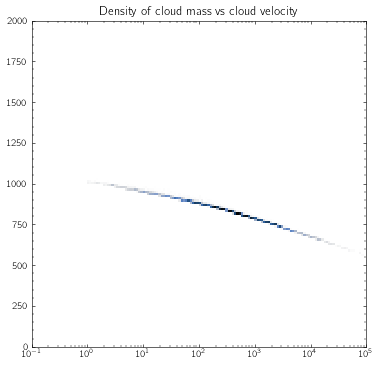

In [12]:
res.plot_density(steps, res, cloud)

In [13]:
x=res.integrateNFlux([0,steps],cloud)
x,x[1]/x[0]

([2114222216.8634143, 793833083.7139807], 0.3754728700617306)

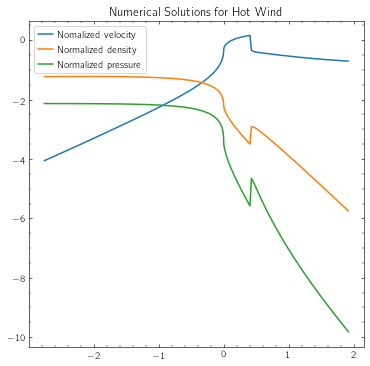

In [13]:
res.plot_wind()

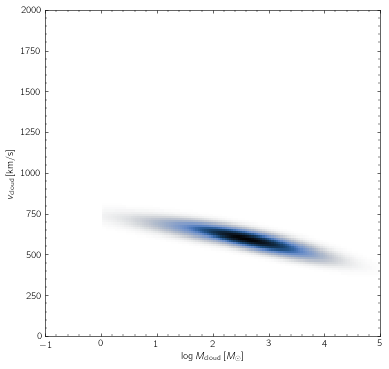

In [16]:
res.plot_cloud([0,steps], cloud)

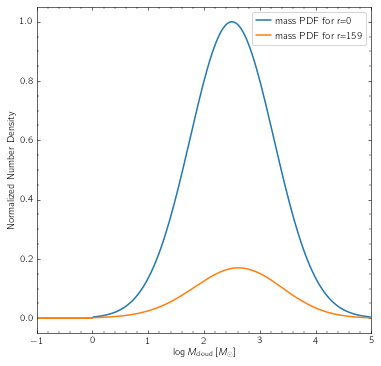

In [248]:
res.plot_mass([0,steps-1], cloud)

In [ ]:
res.plot_velocity([0,steps], cloud)


In [ ]:
res.plot_cloud([steps], cloud)

In [ ]:
res.plot_cloud([1], cloud)

In [ ]:
filename = "phase_space.csv"
f = res.cloud_f[1]
res.save_grid(filename,f, cloud)

In [ ]:
filename = "cloud_mass.csv"
f = cloud.M_cloud
res.save_grid(filename, f, cloud)

In [ ]:
filename = "Mdot_over_v.csv"
f = cloud.Mdot_over_v
res.save_grid(filename, f, cloud)

In [ ]:
filename = "vdot_over_v.csv"
f = cloud.vdot_over_v
res.save_grid(filename, f, cloud)

In [ ]:
filename = "M_left.csv"
f = cloud.m_left
res.save_grid(filename, f, cloud)

In [ ]:
filename = "M_right.csv"
f = cloud.m_right
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_m0.csv"
f = control.cfl_m0[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_m1.csv"
f = control.cfl_m1[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_v0.csv"
f = control.cfl_v0[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_v1.csv"
f = control.cfl_v1[0]
res.save_grid(filename, f, cloud)

In [ ]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)


res = Result(const, pm)
wind = Wind(control, const, pm, res)
cloud = CloudMC(wind, control, const, pm, res)
# cloud = Cloud(wind, control, const, pm, res)


In [ ]:
rhoz = res.wind_rhoz
r = res.wind_r
rhoz[0]
res.wind_rhoz[-1], res.wind_rho[-1]

In [ ]:
plt.plot(r,rhoz)

In [ ]:
pm['CLOUD_METALLICITY']

In [ ]:
pm['V_MU']

In [ ]:
wind.metallicity

In [ ]:
res.wind_rho_dot[400], res.wind_p_dot[0], res.wind_epsilon_dot[0]

In [ ]:
res.wind_rho[-1]

In [ ]:
res.wind_P[-1]

In [ ]:
res.clouds[-1]

In [ ]:
sum(res.clouds[10][:,1] * res.clouds[10][:,2])

In [ ]:
sum(res.clouds[10][:,1] * res.clouds[10][:,2])

In [ ]:
sum(res.clouds[-1][:,1] * res.clouds[-1][:,2])

In [ ]:
res.clouds[0][:1][0]

In [ ]:
a = res.clouds[1600][:,0]/const.Msun
min(a)

In [350]:
cloud.retiredCloud

AttributeError: 'Cloud' object has no attribute 'retiredCloud'

In [391]:
min(abs(cloud.dr_M / const.pc))

13.78638070975747

In [392]:
min(abs(cloud.dr_v / const.pc))

4.275299220118284

In [432]:
len(res.clouds)

161

In [51]:
def getCloudSource(dot_params, wind_params, cloud_params, aux_params):        
    Mdot_grow, Mdot_loss = dot_params
    P, v, rho = wind_params
    M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
    dr, dvol, gamma, retire_mass, retire_flag = aux_params

    dt = dr/v_cloud
    Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
    Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)

    n_cloud = N_cloud/dvol
    rhodot = (Mdot_grow + Mdot_loss) * n_cloud
    pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
    epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud                
    return rhodot, pdot, epsilondot    

In [50]:
res.wind_rho_dot

array([ 2.26135874e-38, -3.12207697e-39, -2.93671189e-39, -3.24984829e-39,
       -3.05592995e-39, -2.82857859e-39, -2.60184408e-39, -2.38924797e-39,
       -2.19460274e-39, -2.01808725e-39, -1.85855625e-39, -1.71445382e-39,
       -1.58417804e-39, -1.46622371e-39, -1.35923035e-39, -1.26199048e-39,
       -1.17344109e-39, -1.09264957e-39, -1.01879811e-39, -9.51168909e-40,
       -8.89130878e-40, -8.32127948e-40, -7.79668937e-40, -7.31318933e-40,
       -6.86691909e-40, -6.45444393e-40, -6.07270045e-40, -5.71895040e-40,
       -5.39074094e-40, -5.08587029e-40, -4.80235821e-40, -4.53842031e-40,
       -4.29244586e-40, -4.06297835e-40, -3.84869858e-40, -3.64840986e-40,
       -3.46102497e-40, -3.28555472e-40, -3.12109789e-40, -2.96683226e-40,
       -2.82200671e-40, -2.68593432e-40, -2.55798606e-40, -2.43758521e-40,
       -2.32420242e-40, -2.21735134e-40, -2.11658458e-40, -2.02149021e-40,
       -1.93168860e-40, -1.84682949e-40, -1.76658941e-40, -1.69066941e-40,
       -1.61879288e-40, -

In [191]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
res = Result(const, pm)
wind = Wind(control, const, pm, res)
cloud = Cloud(wind, control, const, pm, res) 
(Mdot,vdot,Mdot_grow,Mdot_loss,rho_clouds)= Utils.dot_cloud_calc(wind.P, wind.v, wind.rho, cloud.M_cloud, cloud.v_cloud, pm)
r_curr, r_next, dr, dvol = control.get_cloudr_info()

In [205]:
dot_params = (Mdot_grow, Mdot_loss)
wind_params = (wind.P, wind.v, wind.rho)
cloud_params = (cloud.M_cloud, cloud.v_cloud, cloud.f, rho_clouds)
aux_params = (dr, dvol, gamma, cloud.retire_mass, cloud.retire_flag)  

In [206]:
Mdot_grow, Mdot_loss = dot_params
P, v, rho = wind_params
M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
dr, dvol, gamma, retire_mass, retire_flag = aux_params
dt = dr/v_cloud
Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)
n_cloud = N_cloud/dvol
rhodot = (Mdot_grow + Mdot_loss) * n_cloud
pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud    

In [207]:
sum(rhodot*cloud.integrateDelta), sum(pdot*cloud.integrateDelta), sum(epsilondot*cloud.integrateDelta)

(-2.2613587382326457e-38, 2.0692637920846305e-29, 4.136956301974086e-21)

In [208]:
n_cloud = cloud.f / dvol        
rhodot_grow = Mdot_grow * n_cloud
rhodot_loss = Mdot_loss * n_cloud
rhodot = rhodot_grow + rhodot_loss
pdot = (v * Mdot_grow + cloud.v_cloud * Mdot_loss) * n_cloud
vB_2 = 0.5 * v**2 + cloud.gamma / (cloud.gamma - 1) * P / rho   # leave out escape velocity
vB_cloud_2 = 0.5 * cloud.v_cloud**2 + cloud.gamma / (cloud.gamma - 1) * P / rho_cloud
epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud

In [209]:
sum(rhodot*cloud.integrateDelta), sum(pdot*cloud.integrateDelta), sum(epsilondot*cloud.integrateDelta)

(-2.2613587382326457e-38, 2.0692637920846305e-29, 4.136956301974086e-21)

In [138]:
cloud.f

array([0., 0., 0., ..., 0., 0., 0.])

In [139]:
cloud.f_last

array([1.18579704e-14, 1.51653309e-14, 1.93400722e-14, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [167]:
retire_mass

2e+33

In [168]:
const.Msun

2e+33

In [506]:
a=np.array([])

In [507]:
a

array([], dtype=float64)

In [508]:
b=np.array([1,2,3])

In [509]:
a=b

In [510]:
a

array([1, 2, 3])

In [211]:
transfer.density_for_source

array([[4.33925811e+35, 8.64293397e+07, 1.04705040e-02],
       [6.14739940e+35, 8.48298716e+07, 1.31396954e-02],
       [1.50078410e+35, 8.99472194e+07, 1.34003902e-02],
       ...,
       [1.92421535e+35, 8.91042859e+07, 1.39776165e-02],
       [6.53899912e+35, 8.45863292e+07, 1.29394366e-02],
       [4.57682161e+36, 7.58270373e+07, 1.19140475e-02]])

In [322]:
transfer.cloudMC_retire

array([[1.62322028e+33, 5.37906684e+06, 1.00000000e+00],
       [8.00646473e+32, 1.61526437e+07, 1.00000000e+00]])

In [327]:
cloud.retiredCloud

array([], dtype=float64)

In [328]:
transfer.cloudMC_retire

array([[1.88338681e+33, 1.41383968e+07, 1.00000000e+00]])

In [ ]:
    @staticmethod
    def getCloudSource(dot_params, wind_params, cloud_params, aux_params):        
        Mdot_grow, Mdot_loss = dot_params
        P, v, rho = wind_params
        M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
        dr, dvol, gamma, retire_mass, retire_flag = aux_params
        
        dt = dr/v_cloud
        Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
        Mdot_loss = np.where(M_cloud < retire_mass, -M_cloud/dt, Mdot_loss)
        
        n_cloud = N_cloud/dvol
        rhodot = (Mdot_grow + Mdot_loss) * n_cloud
        pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
        vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
        vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
        epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud      
        return rhodot, pdot, epsilondot    
    
    @staticmethod
    def retireCloud(M_clouds, v_clouds, N_clouds, retire_mass):
        cloud_stack = np.column_stack((M_clouds, v_clouds, N_clouds))
        cloud_live = np.array([list(item) for item in cloud_stack if item[0] >= retire_mass])
        cloud_retire = np.array([list(item) for item in cloud_stack if item[0] < retire_mass])
        return cloud_live, cloud_retire
